# HOMEWORK 3 - CONTROL DESIGN

**Comments: 98/100**
1. 2 pts off because notebook didn't run as-is. See below. Otherwise, looks good.

In this homework, you will do a complete narrative for control design for your system.
You can use the notebook for lecture 15 (Workflow for control design) as a guide to what is expected.

# Preliminaries

In [1]:
import collections
import control
import controlSBML as ctl
import lmfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [2]:
TIMES = np.linspace(0, 10, 100)

In [3]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
TEST_CTLSB = ctl.ControlSBML(TEST_MODEL, input_names=["S1"], output_names=["S3"])
TEST_SYS = TEST_CTLSB.makeNonlinearIOSystem("TEST_SYS")

In [4]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

In [5]:
# This class captures the results of a designing a closed loop system
class DesignResult(object):
    def __init__(self, grm=None, gnm=None, params=None, det=None):
        """
        Parameters
        ----------
        grm: control.TransferFunction
        gnm: control.TransferFunction
        params: lmfit.Parameters
        det: lmfit.MinimizerResult
        
        """
        self.grm = grm
        self.gnm = gnm
        self.params = params
        self.det = det
        
    def __repr__(self):
        return ""

## ``plotSys``

In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float (default is step)
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "TransferFunction" in str(type(sys)):
        is_nonlinear = False
    else:
        is_nonlinear = True
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(1, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        if len(sys.output_labels) == 1:
            output_labels = ["y"]
        else:
            output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            for idx in range(num_output):
                plt.plot(t, y[idx])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


## ``makeDerivative``

In [7]:
def makeDerivative():
    """
    Returns a funtion that calculates derivatives for a signal.
    
    Returns
    -------
    Function
    """ 
    class Last():
        def __init__(self, t, u):
            self.t = t
            self.u = u
    #
    last = Last(0, 0)
    # Calculate derivative of the input
    def derivative(t, u):
        """
        Parameters
        ----------
        t: float
        u: float
        
        Returns
        -------
        float
        """
        dt = t - last.t
        if dt <= 0:
            du = 0
        else:
            du = (u - last.u)/dt
        last.t = t
        last.u = u
        return du
    #
    return derivative

# Tests
is_plot = False
derivative = makeDerivative()
inputs = np.sin(TIMES)
outputs = [derivative(t, 1) for t in TIMES]
np.allclose(outputs, 0)
#
derivative = makeDerivative()
inputs = np.sin(TIMES)
outputs = [derivative(t, i) for t, i in zip(TIMES, inputs)]
derivative = makeDerivative()
second_inputs = list(outputs)
outputs = [derivative(t, i) for t, i in zip(TIMES, second_inputs)]
if is_plot:
    plt.plot(TIMES, inputs, color="black")
    plt.plot(TIMES, outputs, color="red")
print("OK")

OK


## ``makeCLTransferFunctions``

In [8]:
# grm: G_RM
# gnm: G_NM
# gf: Filter
# gc: Controller
# go: OLS
CLTransferFunctions = collections.namedtuple("CLTransferFunctions",
      "grm gnm gc gf go")
def makeCLTransferFunctions(gO_tf, params, is_warnings=True):
    """
    Makes two closed loop transfer functions.
        G_RM (s) - transfer function from the reference input to the measurement output
        G_NM (s) - transfer function from the noise input to the measurement output
    
    Parameters
    ----------
    gO_tf: control.TransferFunction (open loop transfer function)
    params:
        kP: float (set to 0 if parameter is not present)
        kI: float (set to 0 if parameter is not present)
        kD: float (set to 0 if parameter is not present)
        kF: float (no filter if parameter is absent)
        is_warnings: bool (display warnings)
    
    Returns
    -------
    CLTransferFunctions
    """
    # Extract the parameters if they are present
    if "kP" in params.keys():
        kP = params["kP"].value
    else:
        kP = 0
    if "kI" in params.keys():
        kI = params["kI"].value
    else:
        kI = 0
    if "kD" in params.keys():
        kD = params["kD"]. value
    else:
        kD = 0
    if "kDD" in params.keys():
        kDD = params["kDD"]. value
    else:
        kDD = 0
    if "kF" in params.keys():
        kF = params["kF"].value
    else:
        kF = None
    # Construct PI Controller
    gC_tf = control.TransferFunction([kP], [1]) 
    gC_tf = gC_tf + control.TransferFunction([kI], [1, 0])
    gC_tf = gC_tf + control.TransferFunction([kD, 0], [1])
    gC_tf = gC_tf + control.TransferFunction([kDD, 0, 0], [1])
    # Construct Filter
    if kF is not None:
        gF_tf = control.TransferFunction([kF], [1, kF])
    else:
        gF_tf = control.TransferFunction([1], [1])
    # RM Closed loop Transfer function
    gRM_tf = control.feedback(gC_tf*gO_tf, sys2=gF_tf)
    # NM Closed loop Transfer function
    gNM_tf = control.feedback(1, sys2=gC_tf*gO_tf*gF_tf)
    # Check for improper transfer functions
    for tf_str in ["gRM_tf", "gNM_tf", "gC_tf", "gF_tf", "gO_tf"]:
        tf = eval(tf_str)
        num_dim = np.shape(tf.num)[-1]
        den_dim = np.shape(tf.den)[-1]
        if num_dim > den_dim:
            if is_warnings:
                print("***Warning. %s is an improper transfer function" % tf_str)
    #
    return CLTransferFunctions(grm=gRM_tf, gnm=gNM_tf, gc=gC_tf, gf=gF_tf, go=gO_tf)

# This test generates several warnings
is_plot = False
tf = control.TransferFunction([1], [1, 1])
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=1)
params.add("kD", value=1)
params.add("kDD", value=1)
cltf = makeCLTransferFunctions(tf, params, is_warnings=is_plot)
assert(isinstance(cltf.grm, control.TransferFunction))
assert(isinstance(cltf.gnm, control.TransferFunction))
assert(isinstance(cltf.gc, control.TransferFunction))
dummy_tf = cltf.gc*control.TransferFunction([1], [1, 1, 1]) # Ensure proper Transfer function
_ = plotSys(dummy_tf, forced_input=1, is_plot=is_plot)
plot_response = plotSys(cltf.grm, is_plot=is_plot)
plot_response = plotSys(cltf.gnm, is_plot=is_plot)
# 
params.add("kF", value=1)
cltf = makeCLTransferFunctions(tf, params, is_warnings=is_plot)
assert(isinstance(cltf.grm, control.TransferFunction))
assert(isinstance(cltf.gnm, control.TransferFunction))
assert(isinstance(cltf.gc, control.TransferFunction))
print("OK!")

OK!


## ``designClosedLoop``

OK!


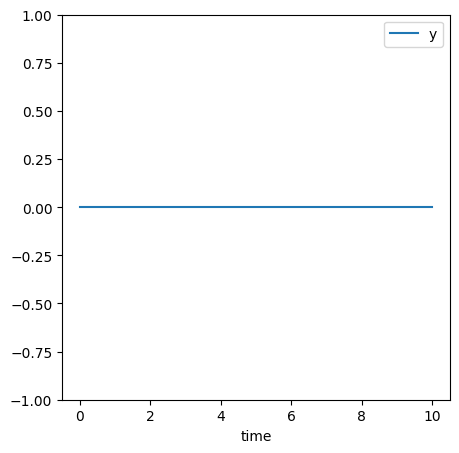

In [9]:
def designClosedLoop(open_loop_tf, is_kP=True, is_kI=True, is_kD=True, is_kDD=False,
                     is_kF=True, amp=1, times=TIMES, kmax=1e4, is_warnings=True):
    """
    Finds parameters for the closed loop system that eliminate noise and have a good step response.
    By default the closed loop system has a PID controller and a filter. By changing is_<k>,
    you can select variations in the design.
    
    Paramters
    ---------
    open_loop_tf: control.TransferFunction (OLS transfer function)
    is_<k>: bool (include the design element)
    amp: 0 <=float  (amplitude of the sine wave used to evaluate noise response)
    times: array-float
    kmax: float (maximum value of a constant)
    
    Returns
    -------
    DesignResult
    """
    NOISE_FREQ = 20*2*np.pi
    step_inputs = np.repeat(1, len(times))
    ideal_step_outputs = step_inputs
    noise_inputs = amp*np.sin(NOISE_FREQ*times) # Sinusoid input
    ideal_noise_outputs = np.repeat(0, len(times))
    def calculateDesignResiduals(params):
        """
        Calculates the residuals with an ideal step response.

        Parameters
        ----------
        params: lmfit.Parameters

        Returns
        -------
        array-float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params, is_warnings=is_warnings)
        gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
        # Calculate residuals for a step response
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        step_residuals = ideal_step_outputs - step_est
        # Calculate residuals for a sinusoidal noise input
        _, sinusoid_est = control.forced_response(gNM_tf, T=times, U=noise_inputs)
        sinusoid_residuals = ideal_noise_outputs - sinusoid_est
        #
        return step_residuals + sinusoid_residuals
    # 
    params = lmfit.Parameters()
    if is_kP:
        params.add("kP", value=1, min=0, max=kmax)
    if is_kI:
        params.add("kI", value=1, min=0, max=kmax)
    if is_kD:
        params.add("kD", value=1, min=0, max=kmax)
    if is_kDD:
        params.add("kDD", value=1, min=0, max=kmax)
    if is_kF:
        params.add("kF", value=1, min=0, max=kmax)
    minimizer_result = lmfit.minimize(calculateDesignResiduals, params)
    new_params = minimizer_result.params
    #
    cltf = makeCLTransferFunctions(gO_tf, new_params, is_warnings=is_warnings)
    gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
    design_result = DesignResult(grm=gRM_tf, gnm=gNM_tf, params=new_params, det=minimizer_result)
    return design_result

# Tests
is_plot = True
gO_tf = control.TransferFunction([1], [1, 1, 1])
design_result = designClosedLoop(gO_tf, kmax=1e10, amp=10, is_kD=True, is_kDD=False, is_warnings=False)
times = np.linspace(0, 10, 100)
noise_inputs = np.sin(20*2*np.pi*times) # Sinusoid i
plotSys(design_result.gnm, times=times, ylim=[-1, 1],
                                          forced_input=noise_inputs, is_plot=is_plot)
assert(isinstance(design_result.grm, control.TransferFunction))
print("OK!")

In [10]:
design_result.params

name,value,standard error,relative error,initial value,min,max,vary
kP,3885582.38,1.4747e+10,(379534.18%),1,0.00000000,1.0000e+10,True
kI,48.5936580,6.7743e+09,(13940757744.75%),1,0.00000000,1.0000e+10,True
kD,20452.3670,1.2348e+10,(60372287.14%),1,0.00000000,1.0000e+10,True
kF,289049.001,8.7851e+12,(3039326889.35%),1,0.00000000,1.0000e+10,True


## ``plotDesignResult``

In [11]:
# Plots of the transfer functions
def plotDesignResult(design_result, ax=None, end_time=50, title="", is_plot=True, **kwargs):
    """
    Plots a DesignResult.
    
    Parameters
    ----------
    design_result: DesignResult
    ax: Matplotlib.Axes
    end_time: float
    is_plot: bool
    kwargs: dict (other plotting options)
    """
    if ax is None:
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (3, 3)
        _, ax = plt.subplots(1, figsize=figsize)
    times = np.linspace(0, end_time, 2000)
    plot_result1 = plotSys(design_result.grm, forced_input=1, times=times, ax=ax,
                         is_legend=False)
    plot_result2 = plotSys(design_result.gnm, forced_input=np.sin(5*times), times=times, 
            is_legend=False, ax=ax)
    if "ylim" in kwargs.keys():
        ylim = kwargs["ylim"]
    else:
        ylim = ax.set_ylim()
    xpos = end_time*1.1
    yspan = ylim[1] - ylim[0]
    ypos1 = ylim[1] - 0.1*yspan
    ypos2 = ypos1 - 0.2*yspan
    ax.text(xpos, ypos1, "G_RM", c="blue")
    ax.text(xpos, ypos2, "G_NM", c="orange")
    ax.set_ylim(ylim)
    ax.set_title(title)
    if not is_plot:
        plt.close()
 
# Tests
plotDesignResult(design_result, kmax=1, figsize= (2,2), is_plot=False, end_time=5)
print("OK!")

OK!


## ``plotStaircaseResponse``

In [12]:
def plotStaircaseResponse(builder, is_plot=True, **kwargs):
    """
    This function circumvents a bug in SISOTransferFunctionBuilder.plotStairCaseResponse.
    It has the same arguments and return value as the original function.
    """
    plot_result = builder.plotStaircaseResponse(is_plot=False, **kwargs)
    # Plot if requested
    if is_plot:
        times = np.array(plot_result.time_series.index)/1000
        df = pd.DataFrame(plot_result.time_series)
        df.index = times
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (10, 10)
        legends = list(df.columns)
        fig, ax = plt.subplots(1, figsize=figsize)
        staircase_column = [c for c in df.columns if "staircase" in c][0]
        staircase_values = df[staircase_column].values
        del df[staircase_column]
        ax.plot(df)
        ax2 = ax.twinx()
        # Plot the staircase
        ax2.plot(times, staircase_values, color="red",
              linestyle="--")
        ax2.set_ylabel(staircase_column, color="red")
        ax.legend(df.columns)
    #
    return plot_result

# TESTS
plot_response = plotStaircaseResponse(LINEAR_BLDR, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=100, is_plot=False)
assert(isinstance(plot_response.time_series, ctl.Timeseries))
print("OK!")

NameError: name 'LINEAR_BLDR' is not defined

**Comment**
1. The notebook failed because you had an unefined symbol. (-2 pts)

## ``makePIController``

In [13]:
def makePIController(kP=20, kI=10):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        output = kI*x[0] + kP*u[0]
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
kP = 10
kI = 20
controller_sys = makePIController(kP=kP, kI=kI)
assert("NonlinearIOSystem" in str(type(controller_sys)))
plot_result = plotSys(controller_sys, forced_input=[1], is_plot=False)
data = plot_result.y_arr
assert(data[0] == kP)
assert(np.isclose(data[-1], kP + plot_result.times[-1]*kI))
print("OK")

OK


## ``makePIDController``

In [14]:
def makePIDController(kP=20, kI=10, kD=0, kDD=0):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    kD: float
    kDD: float (coefficient for second derivative of input)
    
    Returns
    -------
    NonlinearIOSystem
    """
    derivative1 = makeDerivative()
    derivative2 = makeDerivative()
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (sum of input, last input)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        du = derivative1(t, u[0])
        ddu = derivative2(t, du)
        output = kP*u[0] + kI*x[0] + kD*du + kDD*ddu
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
is_plot = False
kP = 10
kI = 20
kD = 100
controller_sys = makePIDController(kP=kP, kI=kI, kD=0)
assert("NonlinearIOSystem" in str(type(controller_sys)))
plot_result = plotSys(controller_sys, forced_input=[1], is_plot=is_plot)
data = plot_result.y_arr
assert(data[0] == kP)
assert(np.isclose(data[-1], kP + plot_result.times[-1]*kI))
#
controller_sys = makePIDController(kP=kP, kI=kI, kD=kD, kDD=10)
inputs = np.sin(TIMES)
plot_result = plotSys(controller_sys, forced_input=inputs, is_plot=is_plot)

print("OK")

OK


## ``makeFilter``

In [15]:
def makeFilter(system_name="filter_sys", kF=1):
    """
    Makes a filter.
    
    Parameters
    ----------
    system_name: str
    kF: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state, averaged signal)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        dy = kF*u[0] - kF*x[0]
        return dy

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return x[0]

    filter_sys = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name=system_name)
    return filter_sys

# Tests
kF = 1
filter_sys = makeFilter(kF=kF)
assert("NonlinearIOSystem" in str(type(filter_sys)))
plot_result = plotSys(filter_sys, forced_input=[1], times=np.linspace(0, 100, 1000), is_plot=False)
data = plot_result.y_arr
assert(np.abs(data[-1] - 1) < 0.01)
print("OK")

OK


## ``makeSinusoid``

In [16]:
def makeSinusoid(system_name="sinusoid_sys", amplitude=1, frequency=20):
    """
    Makes a sinusoidal signal, the only output.
    
    Parameters
    ----------
    system_name: str
    amplitude: float (amplitude of the sinusoid)
    frequency: float (frequencay of the sinusoid)
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return amplitude*np.sin(t*2*np.pi*frequency)

    sinusoid_sys = control.NonlinearIOSystem(
      None,
      outfcn,
      inputs=0,
      outputs=['out'],
      name=system_name)
    return sinusoid_sys

# Tests
sinusoid_sys = makeSinusoid(amplitude=10)
assert("NonlinearIOSystem" in str(type(sinusoid_sys)))
plot_result = plotSys(sinusoid_sys, forced_input=1, times=np.linspace(0, 10, 1000), is_plot=False)
count = len([v for v in plot_result.y_arr[0] if v >= 0.999])
assert(count > 1)
print("OK")

OK


## ``makeAdder``

In [17]:
def makeAdder(input_names, output_name="out", system_name="adder_sys"):
    """
    Creates a NonlinearIOSystem that does addition
    of the inputs. Any name that begins wit a "-" is subtracted.
    
    Parameters
    ----------
    input_nmames: list-str
    output_name: str
    system_name: str
    
    Returns
    -------
    NonlinearIOSystem
    """
    adjustments = []
    adjusted_input_names = []
    def outfcn(_, __, u, ___):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return adjustments.dot(u)
    #
    for name in input_names:
        if name[0] == "-":
            value = -1
            new_name = name[1:]
        else:
            value = 1
            new_name = name
        adjustments.append(value)
        adjusted_input_names.append(new_name)
    adjustments = np.array(adjustments)
    #
    return control.NonlinearIOSystem(
          None,
          outfcn,
          inputs=adjusted_input_names,
          outputs=output_name, name=system_name)

# Tests
adder_sys = makeAdder(["a", "-b", "c"])
assert("NonlinearIOSystem" in str(type(adder_sys)))
# Simulate to verify 
plot_result = plotSys(adder_sys, forced_input=[3, 2, 4], is_plot=False)
data = plot_result.y_arr
assert(np.var(data[0]) == 0)
assert(data[0][0] == 5)
print("OK")

OK


## ``makeClosedLoopSystem``

In [18]:
def makeClosedLoopSystem(ctlsb, kP=1, kI=1, kF=1, kD=0, kDD=0, noise_amplitude=1,
                         noise_frequency=20):
    """
    Create a closed loop system with a controller and filter for an SBML model.
    
    Parameters
    ----------
    ctlsb: ControlSBML (for open loop system)
    kP: float
    kI: float
    kD: float
    kF: float
    noise_amplitude: float
    noise_frequency: float
    
    Returns
    -------
    Interconnect
    """
    # Information for open loop system
    if len(ctlsb.input_names) != 1:
        raise ValueError("Open loop system should have exactly 1 input")
    if len(ctlsb.output_names) != 1:
        raise ValueError("Open loop system should have exactly 1 output")
    open_sys = ctlsb.makeNonlinearIOSystem("open_sys")
    sinusoid_sys = makeSinusoid(system_name="sinusoid_sys",
                                amplitude=noise_amplitude, frequency=noise_frequency)
    open_input = "open_sys.%s" % ctlsb.input_names[0]
    open_output = "open_sys.%s" % ctlsb.output_names[0]
    # Other elements
    filter_sys = makeFilter(kF=kF)
    controller_sys = makePIDController(kP=kP, kI=kI, kD=kD, kDD=kDD)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    adder_sys = makeAdder(["noise", "open_sys"], system_name="adder_sys")
    closed_sys = control.interconnect(
      [adder_sys, sinusoid_sys, open_sys, controller_sys, differ_sys, filter_sys],       # systems
      connections=[
        ['adder_sys.noise', "sinusoid_sys.out"],
        ['adder_sys.open_sys', open_output],
        ['filter_sys.in', "adder_sys.out"],
        ['differ_sys.measurement', 'filter_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
        [open_input, 'controller_sys.out'],
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["adder_sys.out", "controller_sys.out"],
    )
    return closed_sys

# Tests
setpoint = 1
new_closed_sys = makeClosedLoopSystem(TEST_CTLSB, noise_amplitude=1, kP=1, kI=0.1, kD=0.2, kDD=0.1, kF=1000)
assert("Interconnect" in str(type(new_closed_sys)))
plot_result = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 30, 100), 
                      is_plot=False, output_labels=["s5", "control_input"])
data = plot_result.y_arr
assert(data[0][0] == 0)
assert(np.abs(setpoint - data[0][-1]) < 0.2)
print("OK!")

OK!


# Step 1. Problem Statement (15 pts)

## Problem Statement
Describe the control problem that you are addressing.

**System description:**
<br /> Biofilm formation in Bacillus subtilis growing off of glutamate
<br /> Cells distributed in 3 layers: periphery (P), middle (M), interior (I) layers.
<br /> P has easy access to glutamate (G_E) but losing Ammonia quickly
<br /> I consumes leftover glutamate, but less rapid loss of ammonia compared to P
<br /> I controls growth of P by manipulating ammonia supply

<br /> This results in metabolic oscillations in biofilm of B. subtilis


<br /> **Control Problem:**
<br /> Want to control Ammonia in inner layer - Ai (output) via Glutamate in the periphery - Gp (input)

In [19]:
from IPython.display import Image
Image("Bsub_biofilm.png", width = 550, height = 225)

FileNotFoundError: No such file or directory: 'Bsub_biofilm.png'

FileNotFoundError: No such file or directory: 'Bsub_biofilm.png'

<IPython.core.display.Image object>

## System studied
Specify the input and output to your system, simulate its open loop behavior, and plot the results.

#### Determination of OLS input and ouput
Control input u(t) = Gp (Glutamate in periphery)
<br /> Output y(t) = Ai (Ammonia in inner layer)

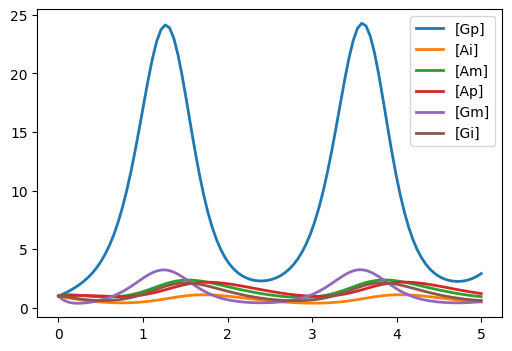

In [20]:
GARDE_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001053.2?filename=Garde2020.xml", 
                        input_names=["Gp"], output_names=["Ai"])
GARDE_RR = GARDE_CTLSB.roadrunner
GARDE_RR.simulate(0, 5, 100)
GARDE_RR.plot()

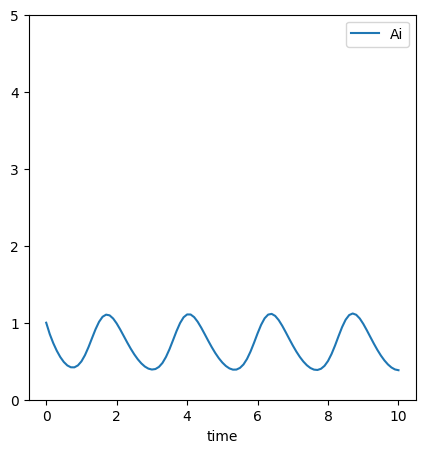

In [21]:
# Simulate the open loop system with no change in its input (Gm)
garde_sys = GARDE_CTLSB.makeNonlinearIOSystem("garde_sys") #command to create the nonlinear IO system for this model
ts = ctl.simulateSystem(garde_sys, end_time=10) #ts = time series object
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[0, 5])

## Control objectives
State the control objectives

<br /> **Control objectives:**
1. Want setpoint to be 0.75 (reducing Ammonia level in inner layer, distributing to outer layer)
2. Reduce oscillations

## Controllability and operating region
1. Do a staircase plot of the control input's effect on the measured output from your system.
1. Determine the operating region, the range of (control) inputs to your system that you will use.

### Plot staircase

### Setup TF builder from Garde model

In [22]:
garde_builder = GARDE_CTLSB.makeSISOTransferFunctionBuilder()
garde_builder.input_name, garde_builder.output_name

('Gp', 'Ai')

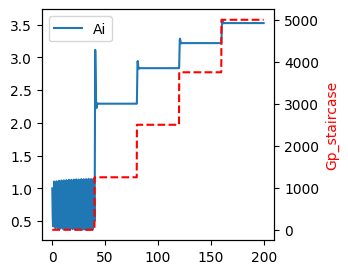

In [23]:
plotStaircaseResponse(garde_builder, initial_value=0, final_value=5000, figsize=(3,3),
                                    num_step=5, legend_crd=(0.5, 1), end_time=200)

# Step 2. System Identification (15 pts)

Here, we estimate a transfer function for the system over the operating range.

## Estimated transfer function

1. Estimate the transfer function over the operating range and evaluate the quality of the estimate by plotting the 
true system output and the output predicted by the transfer function.
1. Show the transfer function.

#### Try: num = 0, denom= 1, operating range 0-5000

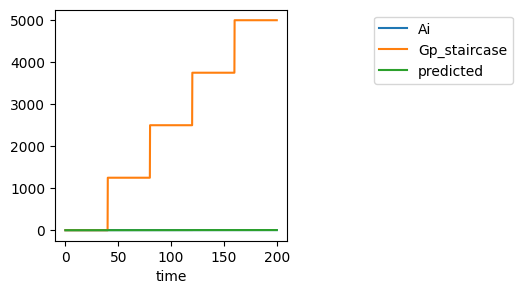

In [24]:
num_degree = 0
denom_degree = 1
fitter_result = garde_builder.fitTransferFunction(num_degree + 1, denom_degree + 1, 
                                                   final_value=5000,
                                                   initial_value=0, end_time=200)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

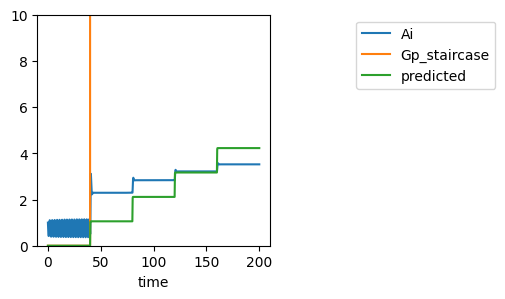

In [25]:
#Zoom In version

num_degree = 0
denom_degree = 1
fitter_result = garde_builder.fitTransferFunction(num_degree + 1, denom_degree + 1, 
                                                   final_value=5000,
                                                   initial_value=0, end_time=200)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1), ylim=[0,10])

#### Printing Transfer function

In [26]:
GARDE_TRANSFER_FUNCTION = fitter_result.transfer_function
print(GARDE_TRANSFER_FUNCTION)


    0.006223
----------------
0.5824 s + 7.363



## Evaluation of the quality of the estimated transfer function

Analyze the expected impact of the accuracy of the transfer function on the closed loop design.

In [27]:
GARDE_TRANSFER_FUNCTION.dcgain()

0.0008452610451268772

**Analysis of DC gain:** DC gain far from 1, need a LARGE input to manipulate output only slightly

In [28]:
GARDE_TRANSFER_FUNCTION.poles()

array([-12.64091167+0.j])

**Analysis of poles:** pole is very negative, system will eventually be stable

**Transfer function (TF) EVALUATION**

1. Higher degree TF resulted in a much lower DC gain, even went negative.
2. As TF's degrees increases, poles also went closer to 0.

<br/> Thus, we are stuck with numerator degree 0 and denominator degree of 1

# Step 3. Optimization-Based Control Design (40 pts)

1. Designs a closed loop system that achieves our control objectives. By "design" is meant finding values
of $k_P, k_I, k_D, k_F$.
1. Consider noise in the design. Noise is specified by a high frequency sinewave, 20 Hz.

#### DON'T RUN CELL!
**At low amp=1, kmax=5 and without D controller :**
System went unstable

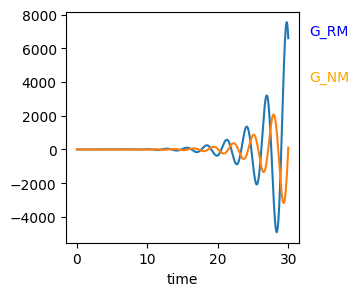

In [29]:
#DON'T RUN CELL!

times = np.linspace(0, 30, 200)
GARDE_DESIGN_RESULT  = designClosedLoop(GARDE_TRANSFER_FUNCTION, kmax=5,
                                       is_kD=False,
                                 amp=1, times=times, is_warnings=False)
plotDesignResult(GARDE_DESIGN_RESULT, end_time=max(times))

#### At low amp=1, kmax=5 and with D controller:
looks like DC gain is now 1, but noise still persists. D controller is definitely needed to stabilize the system

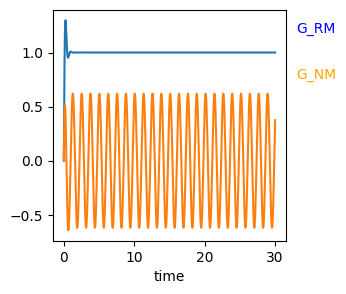

In [30]:
times = np.linspace(0, 30, 200)
GARDE_DESIGN_RESULT  = designClosedLoop(GARDE_TRANSFER_FUNCTION, kmax=10,
                                       is_kD=True, is_kP= True, is_kI= True, is_kF= True,
                                 amp=10, times=times, is_warnings=False)
plotDesignResult(GARDE_DESIGN_RESULT, end_time=max(times))

**Notes on kmax and amp adjustments:** 
<br/> Noise is actually reduced as kmax goes up. The limit of kmax =60, value >60 will drive the system unstable.

<br /> However, when the control is implemented kmax and/or amp values larger than 10 will give RunTime errors.
<br /> I was stuck with kmax =10, amp = 10. With these values, DC gain = 1 pretty fast, and noise amplitude is at least reduced to 0.5.

In [31]:
GARDE_DESIGN_RESULT.params

name,value,standard error,relative error,initial value,min,max,vary
kP,9.99999999,164.525772,(1645.26%),1,0.00000000,10.0000000,True
kI,9.99983349,49.4959999,(494.97%),1,0.00000000,10.0000000,True
kD,10.00000000,15830.2233,(158302.23%),1,0.00000000,10.0000000,True
kF,10.00000000,7203.94831,(72039.48%),1,0.00000000,10.0000000,True


# Step 4. Testbed evaluations (15 pts)

This step builds a testbed for the system designed in the previous step, and does simulation runs to assess performance relative to the control objectives.

In [32]:
SETPOINT = 0.75
GARDE_TIMES = np.linspace(0, 30, 200)

OLS behavior (set kP = kI = 0)

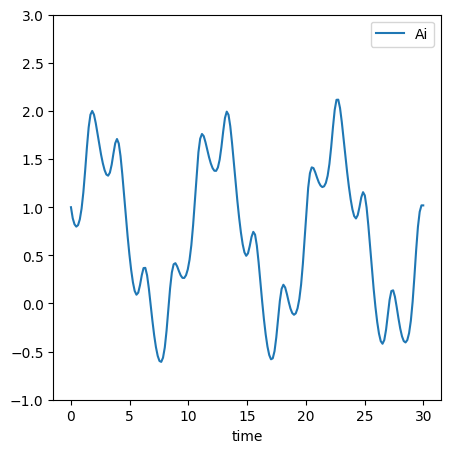

In [33]:
garde_closed_sys = makeClosedLoopSystem(GARDE_CTLSB, kP=0, kI=0, kF=0, noise_amplitude=1)
plot_result = plotSys(garde_closed_sys, forced_input=[SETPOINT], times=GARDE_TIMES, 
                      is_plot=True, output_labels=["Ai"], ylim=[-1, 3])

## Implementation

Use the helper ``makeClosedLoopSystem``to do control design. Some iteration may be required.

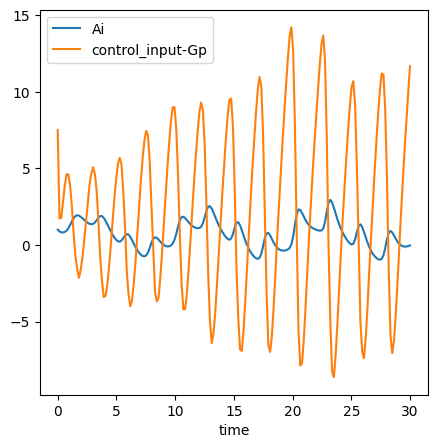

In [34]:
# System with design parameters
kP = GARDE_DESIGN_RESULT.params["kP"].value
kI = GARDE_DESIGN_RESULT.params["kI"].value
kD = GARDE_DESIGN_RESULT.params["kD"].value
if "kF" in GARDE_DESIGN_RESULT.params.keys():
    kF = GARDE_DESIGN_RESULT.params["kF"].value
else:
    kF = 1000
garde_closed_sys = makeClosedLoopSystem(GARDE_CTLSB, kP=kP, kI=kI, kD=kD, kF=kF,
                                      noise_amplitude=1)
plot_result = plotSys(garde_closed_sys, forced_input=[SETPOINT], times=GARDE_TIMES, 
                      is_plot=True, output_labels=["Ai", "control_input-Gp"])

## Tuning

Make any further adjustments to your design using the testbed to evaluate the results. If none adjustments are required, indicate why this is the case.

**Tuning results**
1. I tried making some adjustments to the system but, overall, trying out different (higher degree) transfer functions didn't help as they drove the DC gain and poles to ridiculous values.

<br/> 2. When controllers are implemented, it is clear that D contoller is needed to make the system more stable, reaching DC gain of 1. kmax value is limited to 10 as I got RunTime errors for kmax >10.

<br/> 3. As for noise reduction, amp was lowered to 10. amp of 10 in combination with kmax of 10 gave the best results of both DC gain = 0 and reduced noise.

<br/> 4. With this set up (low order TF, low kmax and amp, as well as PID controller), looks like the system is improved a little bit in a sense that we don't need as high of an input to manipulate output (operating range is lowered significantly). This is because, previously, the OLS transfer function gave a very small DC gain which means we need a very large output in order to change output only slightly.

# Step 5. Discussion (15 pts)

1. How does the operating range of the OLS in the stepbed compare with the operating range you used in Step 2?
1. How well are control objectives achieved?
1. What value (benefit) did you get from doing control design?

1. Operating range after controller was implemented went down significantly (to a magnitude of 15) compared to Step 2's range. In step 2, output as big as 5000 was needed to manipulate ouput (as predicted by the very small, near zero DC gain)

<br/> 2. Unfortunately, the setpoint amplitude of 0.75 was not achieved as shown by worsened oscillation of Ai (ammonia) in the presence of noise (smaller waves within waves). The tug of war between ammonia and glutamate still exists even after implementing a PID controller as shown by the out-of-phase oscillations of Ammonia (Ai) and Glutamate (Gp).

<br/> 3. I think with this control design, I learned that some biological system is just hard to control. It is illustrated with this Ammonia-Glutamate problem because one parameter's behavior is highly influenced by another parameter's behavior.
The higher the dependency of those two parameters, the harder the system is to control. I personally enjoy looking at different scenarios (from changing operating range, transfer function's degrees, and controller parameters) to see how system behave from control design/perturbation.
